# Travel Time Analysis
This notebook aims at analyzing the travels recorded in the Permit Log.

Made assumptions:
 * If time(_Start trip_) == time(_End trip_) → one day of travels
 * The attribute _TotalDeclared_ represents the total amount spend on a permit (declarations and prepaid costs)

In [1]:
from collections import Counter
from statistics import mean
import matplotlib.pyplot as plt

In [2]:
# Load log
import sys
sys.path.insert(1, '../')
from src.io import PER, read_log

permit_log = read_log(PER)

In [3]:
# Setup counter and variables
trip_length_counter = Counter() # Counts the occurences of different trip lengths (nights)
trip_month_counter = Counter()  # Counts the number of trips per month

# Collects the lengths of trips per month
trip_month_length = {1: [], 2: [], 3: [], 4: [], 5:[], 6:[], 7: [], 8: [], 9: [], 10: [], 11: [], 12: []}
# Collects the costs of trips per day per month
trip_month_costs_per_day = {1: [], 2: [], 3: [], 4: [], 5:[], 6:[], 7: [], 8: [], 9: [], 10: [], 11: [], 12: []}

no_excluded = 0             # Number of cases that were excluded from analysis
max_trip_length = 70        # Maximum length of a trip that will be included in the analysis
max_cost_per_day = 100000   # Maximum cost of a trip per day that will be included in the analysis

In [4]:
# Set up functions to compute averages on trip lengths and costs
def calculate_cost_per_day_average():
    for mo in trip_month_costs_per_day:
        trip_month_costs_per_day[mo] = round(mean(trip_month_costs_per_day[mo]), 2)

def calculate_length_average():
    for mo in trip_month_length:
        trip_month_length[mo] = round(mean(trip_month_length[mo]), 1)

In [5]:
# Start analysing traces

for permit in permit_log:
    trip_start = None
    trip_end = None
    total_amount = 0
    
    for event in permit:
        if event["concept:name"] == "Start trip":
            trip_start = event["time:timestamp"]
            continue
        if event["concept:name"] == "End trip":
            trip_end = event["time:timestamp"]
            total_amount = float(event["(case)_TotalDeclared"])
            break

    # Skip cases with have no trip start or trip end
    if ((not trip_start) or (not trip_end)):
        continue

    # Trip length corresponds to the number of overnight stays, might also be zero
    trip_length = (trip_end - trip_start).days

    if (trip_length > max_trip_length):
        no_excluded += 1
        continue

    # Increase counter for found length
    trip_length_counter[trip_length] += 1

    # Increase counter for the month the trip was started in
    trip_month_counter[trip_start.month] += 1

    # Add trip length to current month (for average later)
    trip_month_length[trip_start.month].append(int(trip_length))

    # Add cost per day to current month (for average later)
    cost_per_day = total_amount # There are trips with 0 length -> assume that this means one day
    if (trip_length > 0):
        cost_per_day = total_amount / (trip_length+1)
    if ((cost_per_day > 0) & (cost_per_day < max_cost_per_day)):
        trip_month_costs_per_day[trip_start.month].append(cost_per_day)


# Just make sure everything is correct
assert sum(trip_length_counter.values()) == sum(trip_month_counter.values())

calculate_cost_per_day_average()
calculate_length_average()          

In [6]:
# Print some information
print(f'Only trips not longer than {max_trip_length} days were considered ({sum(trip_length_counter.values())} trips, {no_excluded} excluded).')
print(f'\nThere are {trip_length_counter[0]} trips with length of zero.')
print(f'\nDetected trip lengths (length in nights, frequency):\n{sorted(trip_length_counter.items())}')
print('\nThese are the 10 most common trip lengths in percent:')
[(length, f'{round(count / sum(trip_length_counter.values()) * 100.0, 1)} %') for length, count in trip_length_counter.most_common(10)]     

Only trips not longer than 70 days were considered (6357 trips, 69 excluded).

There are 438 trips with length of zero.

Detected trip lengths (length in nights, frequency):
[(0, 438), (1, 702), (2, 861), (3, 842), (4, 814), (5, 731), (6, 555), (7, 410), (8, 238), (9, 141), (10, 108), (11, 74), (12, 47), (13, 48), (14, 52), (15, 36), (16, 37), (17, 19), (18, 6), (19, 11), (20, 13), (21, 14), (22, 20), (23, 7), (24, 10), (25, 4), (26, 1), (27, 2), (28, 3), (29, 7), (30, 12), (31, 11), (32, 8), (33, 5), (34, 5), (35, 8), (36, 2), (37, 5), (38, 2), (39, 3), (40, 2), (41, 2), (42, 2), (44, 2), (45, 2), (46, 3), (48, 4), (49, 1), (50, 4), (51, 1), (52, 1), (54, 1), (55, 3), (57, 1), (59, 1), (60, 1), (61, 3), (62, 6), (63, 1), (64, 2), (66, 2)]

These are the 10 most common trip lengths in percent:


[(2, '13.5 %'),
 (3, '13.2 %'),
 (4, '12.8 %'),
 (5, '11.5 %'),
 (1, '11.0 %'),
 (6, '8.7 %'),
 (0, '6.9 %'),
 (7, '6.4 %'),
 (8, '3.7 %'),
 (9, '2.2 %')]

## Plot Statistics on Trips
### Distribution of Trip Lengths

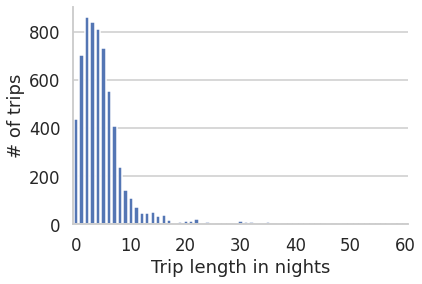

In [7]:
# Plot trip lengths
import seaborn as sns
sns.set(context="talk", style="whitegrid")

ax = sns.barplot(
    x=list(trip_length_counter.keys()),
    y=list(trip_length_counter.values()),
    color="#4472C4")
ax.set(xlabel='Trip length in nights', ylabel='# of trips')

ax.axes.xaxis.set_ticks([0,10,20,30,40,50,60])
ax.axes.xaxis.set_ticklabels([0,10,20,30,40,50,60])
sns.despine()

### Distribution of Trips on Months
Including the average trip length per month

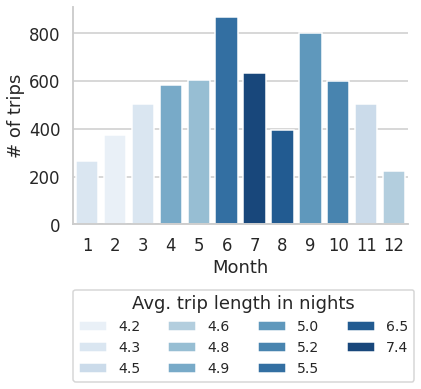

In [8]:
# Plot number of trips per month
month_key_list = list(trip_month_counter.keys())
month_counter_list = list(trip_month_counter.values())
avg_length_list = list(trip_month_length[mo] for mo in month_key_list)

ax = sns.barplot(
    x=month_key_list,
    y=month_counter_list,
    hue=avg_length_list, palette="Blues",
    dodge=False)
ax.set(xlabel='Month', ylabel='# of trips')

plt.legend(bbox_to_anchor=(0, -0.3), loc=2, ncol=4, borderaxespad=0., title='Avg. trip length in nights', prop={'size': 14})
sns.despine()
#plt.savefig("trips_per_month_with_avg_length.svg")


### Average Cost of a Travel Day per Month

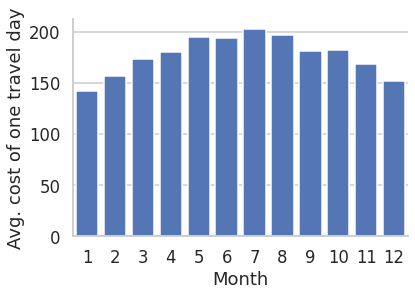

In [9]:
# Plot average costs per day of trips per month
avg_cost_list = list(trip_month_costs_per_day[mo] for mo in month_key_list)

ax = sns.barplot(
    x=month_key_list,
    y=avg_cost_list,
    color="#4472C4")
ax.set(xlabel='Month', ylabel='Avg. cost of one travel day')
sns.despine()
#plt.savefig("avg_cost_of_travelday_per_month.svg")